In [1]:
#!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O nyu.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import numpy as np
from PIL import Image


def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    #print("Before images.shape=", images.shape)
    #print("Before len(images.shape)=",  len(images.shape))
    #if len(images.shape) < 3: images = np.stack((images,images,images), axis=3)
    #print("After images.shape=", images.shape)
    #if len(images.shape) <3 : images = np.stack((images,images,images), axis=1)
    #if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    #images1 = np.stack((images,images,images), axis=3)
    #print("Before images1.shape=", images1.shape)
    #images = images1.reshape(-1,160,160,3)

    #print("Before images.shape=", images.shape)
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('plasma')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    
    all_images = []

    for i in range(outputs.shape[0]):
        imgs = []
        
        if isinstance(inputs, (list, tuple, np.ndarray)):
            x = to_multichannel(inputs[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if isinstance(gt, (list, tuple, np.ndarray)):
            x = to_multichannel(gt[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(plasma(rescaled)[:,:,:3])
        else:
            imgs.append(to_multichannel(outputs[i]))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)
    
    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e

In [2]:
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [4]:
!pip install scikit-image

  Using cached scikit_image-0.16.2-cp37-cp37m-win_amd64.whl (25.7 MB)
  Using cached PyWavelets-1.1.1-cp37-cp37m-win_amd64.whl (4.2 MB)
  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)


In [4]:
%matplotlib inline
import os
import glob
import argparse
import matplotlib
import scipy.misc

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
#from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt

# Argument Parser
#parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
#parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
#parser.add_argument('--input', default='examples/*.png', type=str, help='Input filename or folder.')
#args = parser.parse_args()

model_name = 'nyu.h5'
#input = 'input1/*.png'
#input = 'bg_fg_grey_images/*.jpg'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
#model = load_model(args.model, custom_objects=custom_objects, compile=False)
model = load_model(model_name, custom_objects=custom_objects, compile=False)

#print('\nModel loaded ({0}).'.format(args.model))
print('\nModel loaded ({0}).'.format(model_name))



Loading model...

Model loaded (nyu.h5).


In [5]:
import os
# Input images
def get_file_list(path) :
    return  [path + '/' + f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

#input_dir='bg_fg_grey_images'
for batch in ['batch1', 'batch2', 'batch3', 'batch4', 'batch5']:
    print("Working for batch: " + batch) 
    input_dir= batch + '/fg_bg_jpg'
    output_dir=batch + '/depth_fg_bg_jpg'

    if os.path.exists(output_dir) == False:
        os.makedirs(output_dir)


    input_file_list = get_file_list(input_dir)
    batch_size=32

    input_file_list_size = len(input_file_list)
    for index in range(0, input_file_list_size, batch_size):
        start_index = index
        if index + batch_size > input_file_list_size:
            end_index = input_file_list_size
        else:
            end_index = index + batch_size
        
        input_batch_file_list = input_file_list[start_index:end_index]
        inputs = load_images(input_batch_file_list)
        print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
        #print("Before inputs.shape=", inputs.shape)
        inputs1 = np.stack((inputs,inputs,inputs), axis=3)
        #print("inputs1.shape=", inputs1.shape)
        inputs = inputs1.reshape(-1,160,160,3)
        #print("After inputs.shape=", inputs.shape)
        outputs = predict(model, inputs, batch_size=batch_size)
        print("Prediction Done")
        outputs1 = outputs.reshape(-1, 80, 80)
        for j,input_batch_file in enumerate(input_batch_file_list):
            #print("input_batch_file: ",input_batch_file)
            output_file_name = input_batch_file[input_batch_file.rindex('/')+1:]
            #print(" output_file_name: ", output_file_name)
            output_full_path = output_dir + "/depth_" + output_file_name
            #im = Image.fromarray((outputs1[j] * 255).astype(np.uint16))
            #im = Image.fromarray(np.uint32(outputs1[j] * 255))
            #im = Image.fromarray(outputs1[j])
            #im.save(output_full_path)
            #scipy.misc.imsave(output_batch_file, outputs1[j])
            #save_images(output_full_path, outputs1[j])
            plt.imshow(outputs1[j])
            plt.savefig(output_full_path)
        

#viz = display_images(outputs.copy(), inputs.copy())
#plt.figure(figsize=(10,5))
#plt.imshow(viz)
#plt.savefig('test.png')
#plt.show()

Working for batch: batch1

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of size (160, 160).
Prediction Done

Loaded (32) images of

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000028AC5A84678> (for post_execute):


KeyboardInterrupt: 

Working for batch: batch1

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Load

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) i

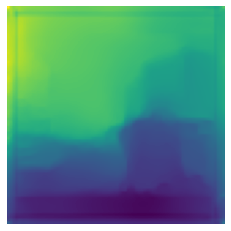

In [10]:
import os
import imageio
# Input images
def get_file_list(path) :
    return  [path + '/' + f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

#input_dir='bg_fg_grey_images'
for batch in ['batch1', 'batch4','batch5']:
    print("Working for batch: " + batch) 
    input_dir= batch + '/fg_bg_jpg'
    output_dir=batch + '/depth_fg_bg_jpg'

    if os.path.exists(output_dir) == False:
        os.makedirs(output_dir)


    input_file_list = get_file_list(input_dir)
    batch_size=128

    input_file_list_size = len(input_file_list)
    
    for index in range(0, input_file_list_size, batch_size):
        plt.clf()
        start_index = index
        if index + batch_size > input_file_list_size:
            end_index = input_file_list_size
        else:
            end_index = index + batch_size
        
        input_batch_file_list = input_file_list[start_index:end_index]
        inputs = load_images(input_batch_file_list)
        print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
        #print("Before inputs.shape=", inputs.shape)
        inputs1 = np.stack((inputs,inputs,inputs), axis=3)
        #print("inputs1.shape=", inputs1.shape)
        inputs = inputs1.reshape(-1,160,160,3)
        #print("After inputs.shape=", inputs.shape)
        outputs = predict(model, inputs, batch_size=batch_size)
        print("Prediction Done")
        outputs1 = outputs.reshape(-1, 80, 80)
        for j,input_batch_file in enumerate(input_batch_file_list):
            #print("input_batch_file: ",input_batch_file)
            output_file_name = input_batch_file[input_batch_file.rindex('/')+1:]
            #print(" output_file_name: ", output_file_name)
            output_full_path = output_dir + "/depth_" + output_file_name
            #im = Image.fromarray((outputs1[j] * 255).astype(np.uint16))
            #im = Image.fromarray(np.uint32(outputs1[j] * 255))
            #im = Image.fromarray(outputs1[j])
            #im.save(output_full_path)
            #scipy.misc.imsave(output_batch_file, outputs1[j])
            #save_images(output_full_path, outputs1[j])
            plt.cla()
            plt.axis('off')
            plt.imshow(outputs1[j])
            #plt.cla()            
            plt.savefig(output_full_path)
            #rescaled =(255.0*outputs1[j]).astype(np.uint8)
            #imageio.imwrite(output_full_path, rescaled)
            
        

#viz = display_images(outputs.copy(), inputs.copy())
#plt.figure(figsize=(10,5))
#plt.imshow(viz)
#plt.savefig('test.png')
#plt.show()

In [9]:
255*outputs1.max()

57.249308824539185

In [11]:
outputs1[0]

array([[0.18563294, 0.17299673, 0.16955157, ..., 0.16186409, 0.16624936,
        0.17275009],
       [0.17508398, 0.17382357, 0.16969363, ..., 0.16198377, 0.16609049,
        0.1662734 ],
       [0.17050561, 0.1721726 , 0.16743232, ..., 0.1624074 , 0.16380025,
        0.16414116],
       ...,
       [0.13115403, 0.12917812, 0.12708554, ..., 0.13796525, 0.1405898 ,
        0.14522001],
       [0.13335921, 0.13348372, 0.13062495, ..., 0.14114372, 0.1445938 ,
        0.14756128],
       [0.1428052 , 0.13666975, 0.13250919, ..., 0.13961239, 0.14539005,
        0.15456739]], dtype=float32)

In [15]:
#rescaled =(255.0*outputs1[0]).astype(np.uint8)
outputs1_0 = outputs1[0]
rescaled = (255/outputs1_0.max())*(outputs1_0-outputs1_0.min())
im = Image.fromarray(rescaled)
#im = im.convert("L")
im = im.convert("L")
im.save('just_test.jpg', "JPEG")


Loaded (128) images of size (160, 160).
Prediction Done

Loaded (128) images of size (160, 160).
Prediction Done


KeyboardInterrupt: 

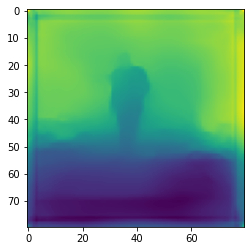

In [8]:
import os
# Input images
def get_file_list(path) :
    return  [path + '/' + f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

#input_dir='bg_fg_grey_images'
input_dir='batch1/fg_bg_jpg'
output_dir='batch1/depth_fg_bg_jpg'

if os.path.exists(output_dir) == False:
    os.makedirs(output_dir)


input_file_list = get_file_list(input_dir)
batch_size=128

input_file_list_size = len(input_file_list)
for index in range(0, input_file_list_size, batch_size):
    start_index = index
    if index + batch_size > input_file_list_size:
        end_index = input_file_list_size
    else:
        end_index = index + batch_size
        
    input_batch_file_list = input_file_list[start_index:end_index]
    inputs = load_images(input_batch_file_list)
    print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
    #print("Before inputs.shape=", inputs.shape)
    inputs1 = np.stack((inputs,inputs,inputs), axis=3)
    #print("inputs1.shape=", inputs1.shape)
    inputs = inputs1.reshape(-1,160,160,3)
    #print("After inputs.shape=", inputs.shape)
    outputs = predict(model, inputs, batch_size=128)
    print("Prediction Done")
    outputs1 = outputs.reshape(-1, 80, 80)
    for j,input_batch_file in enumerate(input_batch_file_list):
        #print("input_batch_file: ",input_batch_file)
        output_file_name = input_batch_file[input_batch_file.rindex('/')+1:]
        #print(" output_file_name: ", output_file_name)
        output_full_path = output_dir + "/depth_" + output_file_name
        #im = Image.fromarray((outputs1[j] * 255).astype(np.uint16))
        #im = Image.fromarray(np.uint32(outputs1[j] * 255))
        #im = Image.fromarray(outputs1[j])
        #im.save(output_full_path)
        #scipy.misc.imsave(output_batch_file, outputs1[j])
        #save_images(output_full_path, outputs1[j])
        plt.imshow(outputs1[j])
        plt.savefig(output_full_path)
        

#viz = display_images(outputs.copy(), inputs.copy())
#plt.figure(figsize=(10,5))
#plt.imshow(viz)
#plt.savefig('test.png')
#plt.show()

In [7]:
outputs.shape

(8, 80, 80, 1)

In [16]:
outputs1 = outputs.reshape(-1, 80, 80)

In [17]:
outputs1.shape

(8, 80, 80)

In [18]:
outputs1[0]

array([[0.23925357, 0.22053295, 0.21472768, ..., 0.2217455 , 0.22834487,
        0.23837909],
       [0.22662327, 0.22285645, 0.21708666, ..., 0.21905397, 0.22229135,
        0.2264339 ],
       [0.21759768, 0.21932992, 0.21307483, ..., 0.21996535, 0.2232311 ,
        0.22081079],
       ...,
       [0.17163438, 0.1682929 , 0.16317278, ..., 0.1525055 , 0.15591604,
        0.1604032 ],
       [0.17655371, 0.17174783, 0.16807762, ..., 0.1538004 , 0.15885617,
        0.16213018],
       [0.18234293, 0.17612962, 0.1709661 , ..., 0.15236185, 0.15969166,
        0.16984412]], dtype=float32)

In [15]:
outputs1[0].shape

(1, 80, 80)

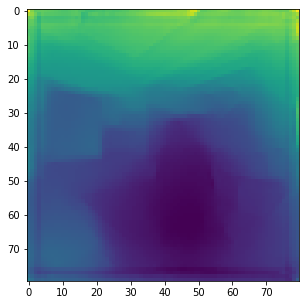

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(outputs1[0])
#plt.savefig('test.png')
plt.show()

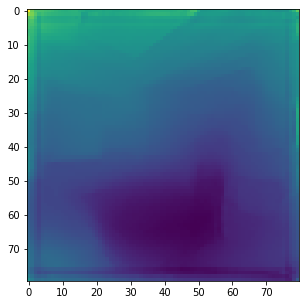

In [20]:
plt.figure(figsize=(10,5))
plt.imshow(outputs1[7])
#plt.savefig('test.png')
plt.show()